In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 30.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from pathlib import Path
import os 
from keras.preprocessing.image import ImageDataGenerator

batch_size = 1
img_size = 72
num_classes = 7
input_shape = (img_size, img_size, 3)

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/mark 2 (V3)/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'    

datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

valid_generator = datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

test_generator = datagen.flow_from_directory(
                      test_data_dir,
                      target_size=(img_size, img_size),
                      class_mode='binary',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [4]:
def extract_x_y(gen):
  x = []
  y = []
  x, y = next(gen)
  for i in range(len(gen)-1):
    x = np.append(x, gen[i+1][0], axis=0)
    y = np.append(y, gen[i+1][1], axis=0)
  return x, y

x_test,y_test = extract_x_y(test_generator)
x_valid,y_valid = extract_x_y(valid_generator)
x_train,y_train = extract_x_y(train_generator)

In [5]:
print("before reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_valid = y_valid.reshape((35,1))
y_train = y_train.reshape((280,1))
y_test = y_test.astype(int)
y_valid = y_valid.astype(int)

print("\n\nafter reshape: ")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_valid shape: {x_test.shape} - y_valid shape: {y_test.shape}")

before reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280,)
x_test shape: (35, 72, 72, 3) - y_test shape: (35,)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35,)


after reshape: 
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)
x_valid shape: (35, 72, 72, 3) - y_valid shape: (35, 1)


In [6]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = img_size  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1


In [7]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


In [8]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


In [9]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [10]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [11]:
def create_model():
  input = layers.Input(input_shape)
  x = layers.RandomCrop(image_dimension, image_dimension)(input)
  x = layers.RandomFlip("horizontal")(x)
  x = PatchExtract(patch_size)(x)
  x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
  x = SwinTransformer(
      dim=embed_dim,
      num_patch=(num_patch_x, num_patch_y),
      num_heads=num_heads,
      window_size=window_size,
      shift_size=0,
      num_mlp=num_mlp,
      qkv_bias=qkv_bias,
      dropout_rate=dropout_rate,
  )(x)
  x = SwinTransformer(
      dim=embed_dim,
      num_patch=(num_patch_x, num_patch_y),
      num_heads=num_heads,
      window_size=window_size,
      shift_size=shift_size,
      num_mlp=num_mlp,
      qkv_bias=qkv_bias,
      dropout_rate=dropout_rate,
  )(x)
  x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
  x = layers.GlobalAveragePooling1D()(x)
  output = layers.Dense(7, activation="softmax")(x)
  model = keras.Model(inputs=input, outputs=output)
  print(model.summary())
  return model


In [12]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=80,
    validation_data=(x_test,y_test),
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 random_crop (RandomCrop)    (None, 72, 72, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 72, 72, 3)         0         
                                                                 
 patch_extract (PatchExtract  (None, 1296, 12)         0         
 )                                                               
                                                                 
 patch_embedding (PatchEmbed  (None, 1296, 64)         83776     
 ding)                                                           
                                                                 
 swin_transformer (SwinTrans  (None, 1296, 64)         50072 

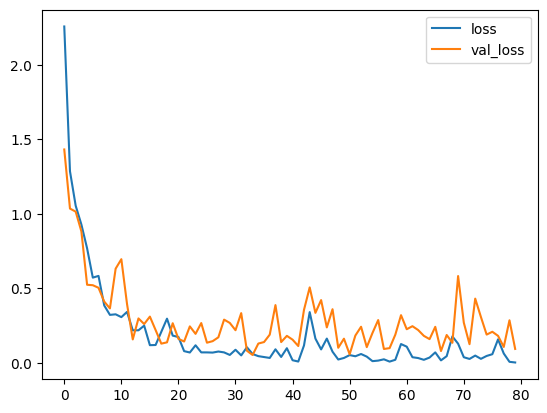

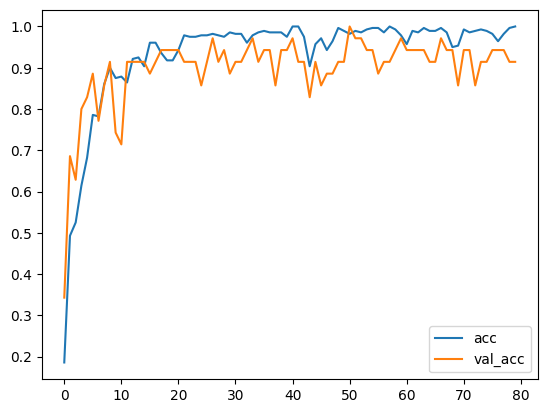

In [13]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()


2/2 [==============================] - 1s 11ms/step
Precisão: 0.9142857142857143


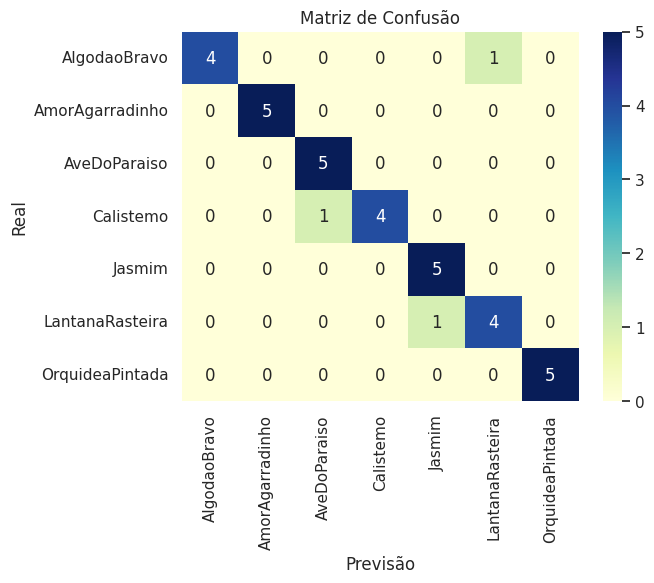

In [15]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_test)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_test

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [16]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

2/2 [==============================] - 0s 14ms/step - loss: 0.1147 - accuracy: 0.9143 - top-5-accuracy: 1.0000
Test loss: 0.11
Test accuracy: 91.43%
Test top 5 accuracy: 100.0%


2/2 [==============================] - 0s 11ms/step
Precisão: 0.9428571428571428


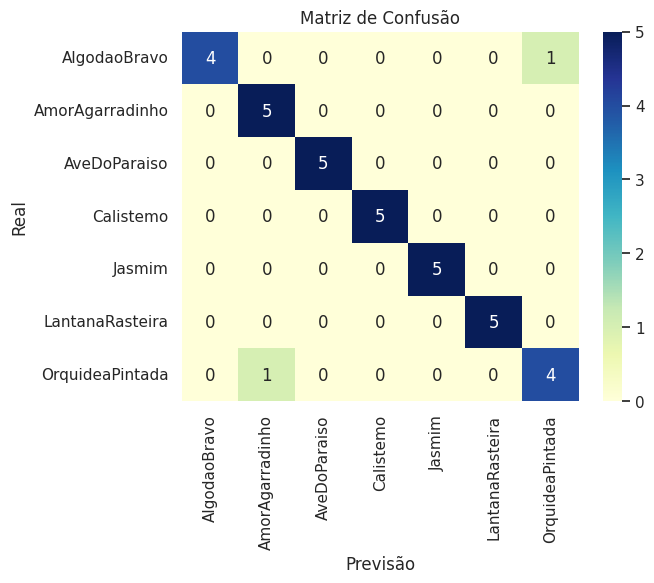

In [17]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Gerar previsões para o conjunto de dados de validação
predictions = model.predict(x_valid)

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions,axis=1)
predicted_classes = predicted_classes.reshape((35,1))

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_valid

# Obter os nomes das classes
class_names = list(train_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [18]:
loss, accuracy, top_5_accuracy = model.evaluate(x_valid, y_valid)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


2/2 [==============================] - 0s 13ms/step - loss: 0.2063 - accuracy: 0.9429 - top-5-accuracy: 1.0000
Test loss: 0.21
Test accuracy: 94.29%
Test top 5 accuracy: 100.0%
